# Modelization of a social Network

## I Community representation


### 1) Packages

In [28]:
import scipy.optimize as opt
import numpy as np
from math import *
import matplotlib.pyplot as plt
from DataSet import generateDataSet
from igraph import *
from mpl_toolkits.mplot3d import Axes3D

### 2) Definition of the posterior

After Computation we obtain the following posterior:

In [21]:

## Compute the lambdas
def strength(i,j,p,vec):
    summ = 0
    for l in range(p):
        summ += vec[i,l]*vec[j,l]
    return summ

# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def posterior(n,p,k,a,b,w,rho):
    vec = w.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            print(vec[i,u])
            summa += (a-1)*log(abs(vec[i,u])) - b*vec[i,u]
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

Computation of the gradient

In [3]:

# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def gradientPosterior_r_s(n,p,k,a,b,w,rho,r,s):
    vec = w.reshape((n,p))
    summ = 0
    
    ## Prior
    summ += (a-1)/(vec[r,s]) - b
    
    ## First term
    for j in range(k):
        summ += vec[rho[r,j],s]/(strength(r,rho[r,j],p,vec))
    
    ## Second Term
    for i in range(n):
        if i != r:
            for j in range(k):
                if rho[r,j] == r:
                    summ += vec[i,s]/(strength(i,r,p,vec))
    
    ## Third Term and fifth term
    totalStrength = 0
    totalW = 0
    listIndex = [l for l in range(n)]
    del listIndex[r]
    for u in (listIndex):
        totalStrength += strength(r,u,p,vec)
        totalW += vec[u,s]
    stateStrength = 0
    stateW = 0
    sumBis = 0
    for j in range(k):
        totalStrength -= stateStrength
        totalW -= stateW
        sumBis += totalW/totalStrength
        stateStrength = strength(r,rho[r,j],p,vec)
        stateW = vec[rho[r,j],s]
    summ -= sumBis
    
    ## Fourth Term and Sixth term
    for i in listIndex:
        totalStrength = 0
        totalW = vec[i,s]
        listIndexBis = [l for l in range(n)]
        del listIndexBis[i]
        for u in (listIndexBis):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        sumBis = 0
        for j in range(k):
            totalStrength -= stateStrength
            totalW -= stateW
            sumBis += totalW/totalStrength
            stateStrength = strength(i,rho[i,j],p,vec)
            if rho[i,j] == r:
                stateW = vec[i,s]
            else:
                stateW = 0
        summ -= sumBis
    return summ

def gradientPosterior(n,p,k,a,b,w,rho):
    return (np.array([[gradientPosterior_r_s(n,p,k,a,b,w,rho,r,s) for s in range(p)] for r in range(n)])).reshape(n*p,)

Test Derivation posterior

In [16]:
n = 3
p = 2
k = 2
a = 2
b = 1
r = 0
s = 0
def generateRank(n,k):
    sol = [np.random.choice([j for j in range(i)] + [j for j in range(i + 1,n)], k, replace = False) for i in range(n)]
    return np.array(sol)

w = np.array([[1.,1],[1,1],[1,1]])
rho = np.array([[2,1],[0,2],[1,0]])
print(w)
print(rho)

[[1. 1.]
 [1. 1.]
 [1. 1.]]
[[2 1]
 [0 2]
 [1 0]]


In [92]:
der = gradientPosterior_r_s(n,p,k,a,b,w,rho,r,s)
print(der)
w1 = w
print(w)
w2 = np.zeros((n,p))
eps = 0.000001
w2[0,0] = eps
w3 = w1 + w2
print("posteriorav ",posterior(n,p,k,a,b,w,rho))
print("posteriorap: ",posterior(n,p,k,a,b,w3,rho))
((posterior(n,p,k,a,b,w3,rho) - posterior(n,p,k,a,b,w,rho)))/(eps)

r: 0
s: 0
-0.25
[[1. 1.]
 [1. 1.]
 [1. 1.]]
posteriorav  -8.079441541679836
posteriorap:  -8.079441541680398


-5.613287612504791e-07

### 3) Optimization

In [3]:
def optimize(n,p ,k,a,b,rho,w0):
    costFunction = lambda w : (-1)*posterior(n,p,k,a,b,w,rho)
    #w0 = (1/p)*np.ones(n*p) ## Initialization
    consMat = [[1 for i in range(p)] + [0 for i in range((n-1)*p)]] + [([0 for i in range(j*p)] + [1 for i in range(p)] + [0 for i in range((n-j-1)*p)]) for j in range(1,n-1)] + [[0 for i in range((n-1)*p)] + [1 for i in range(p)]]
    A = np.concatenate((np.eye(n*p), np.array(consMat)), axis=0)
    lowb = np.array([0 for i in range(n*p)] + [1 for i in range(n)])
    uppb = np.array([1 for i in range(n*(p+1))])
    return opt.minimize(costFunction,w0,bounds = [(0,1) for i in range(n*p)])

In [84]:
def optimizeWithGradient(n,p ,k,a,b,rho,w0):
    costFunction = lambda w : (-1)*posterior(n,p,k,a,b,w,rho)
    gradient = lambda w : (-1)*gradientPosterior(n,p,k,a,b,w,rho)
    return opt.minimize(costFunction,w0, jac = gradient)

In [4]:
def optimize_ab(n,p ,k,rho,w0):
    costFunction = lambda w : (-1)*posterior(n,p,k,w[0],w[1],w[2:],rho)
    return opt.minimize(costFunction,w0,bounds = [(0.5,100),(0.5,100)] + [(0,1) for i in range(n*p)])

## II Test

### 1) Data Generation

##### Random Generation

In [5]:
n = 40
p = 3
k = 4m
a = 1
b = 1
def generateRank(n,k):
    sol = [np.random.choice([j for j in range(i)] + [j for j in range(i + 1,n)], k, replace = False) for i in range(n)]
    return np.array(sol)
rho = generateRank(n,k)
print(rho)

[[ 6 13 22 12]
 [13 36 28  6]
 [22 13 32 11]
 [15 31 33  0]
 [18 17 39 27]
 [30 34 32  2]
 [25 19  3 32]
 [26 39  4  9]
 [12 37 17 21]
 [32 35  8  4]
 [ 0 17  4  6]
 [25  9  5 37]
 [28 10 26  9]
 [ 6  5  0  3]
 [26 11 17 34]
 [26 20 12 33]
 [33 27 29 32]
 [ 0 31 36 12]
 [28 13  4 24]
 [11 25  4 20]
 [28  8 30 18]
 [24  8  7 14]
 [ 7 31 38  1]
 [28 29 25 15]
 [ 3 37 12 14]
 [33 13 29 11]
 [37 38 12 29]
 [13 38  3  5]
 [31 38 32 33]
 [ 2 10 15 36]
 [ 8 28  2 19]
 [32 14 21 16]
 [ 1 25  3 34]
 [ 7  5 27 25]
 [19 11 35 22]
 [18 17  5  0]
 [ 0 33  6 26]
 [ 1 20 13 22]
 [ 6 15 25  5]
 [20  9 22 32]]


##### Sampson's Data Set

In [93]:
## Convert the array from the Sampson's DataSet in the format of the data in the dissertation Proposal
def dataProcessing(arr,k):
    r,s = arr.shape
    sol = np.zeros((r,k),dtype = 'int')
    for i in range(r):
        for j in range(1,k+1):
            for l in range(s):
                if arr[i,l] == j:
                    sol[i,j-1] = int(l)
    return sol

In [94]:
(listData,listLabel) = generateDataSet()
arr = listData[0]
n,p = arr.shape

In [95]:
k = 3
p = 3
a = 1
b = 1
rho = dataProcessing(arr,k)

In [79]:
k = 3
p = 3
rho = dataProcessing(arr,k)

### 2) Posterior Minimization

#### a) Minimization given a and b

In [8]:
exemple = np.array([1,2,3,4,5,6])
np.insert(exemple, 0, 0)
exemple

array([1, 2, 3, 4, 5, 6])

0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.001
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.1030204081632653
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.2050408163265306
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.3070612244897959
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.4090816326530612
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.5111020408163265
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.6131224489795918
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.7151428571428571
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.8171632653061224
0.001
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.9191836734693877
0.001
0.5

0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.46969387755102
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.571714285714285
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.6737346938775506
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.775755102040816
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.877775510204081
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.9797959183673464
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
4.081816326530612
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
4.183836734693878
0.7151428571428571
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187


0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.2252448979591835
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.3272653061224489
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.429285714285714
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.5313061224489792
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.6333265306122446
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.73534693877551
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.8373673469387752
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.9393877551020404
1.5313061224489792
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.0414081632653

3.367673469387755
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.46969387755102
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.571714285714285
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.6737346938775506
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.775755102040816
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.877775510204081
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
3.9797959183673464
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
4.081816326530612
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
4.183836734693878
2.245448979591836
0.5542911346258604
0.3991688708370241
0.253999185250008
0.424137783

0.253999185250008
0.42413778311801187
0.001
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.1030204081632653
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.2050408163265306
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.3070612244897959
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.4090816326530612
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.5111020408163265
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.6131224489795918
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.7151428571428571
3.163632653061224
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
0.8171632653061224
3.163632653061224
0.5542911346258604
0.3991688708370

3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.73534693877551
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.8373673469387752
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.9393877551020404
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.041408163265306
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.1434285714285712
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.245448979591836
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.3474693877551016
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.449489795918367
3.9797959183673464
0.5542911346258604
0.3991688708370241
0.253999185250008
0.4241377831180118

0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
1.9393877551020404
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.041408163265306
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.1434285714285712
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.245448979591836
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.3474693877551016
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.449489795918367
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.5515102040816324
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.653530612244898
4.795959183673469
0.5542911346258604
0.3991688708370241
0.253999185250008
0.42413778311801187
2.755551020408163
4.7959

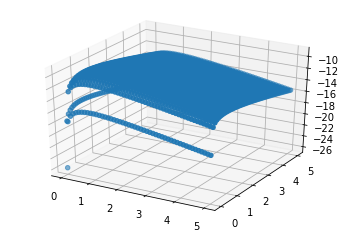

In [47]:
a = 2
"""
w0 =  np.random.rand(n*p - 1)
w0 = w0/10
"""
w = np.random.rand(4)
lin1 = np.linspace(0.001,5,50)
lin2 = np.linspace(0.001,5,50)
lin3 = np.linspace(0.001, 50, 2500)
y = [posterior(n,p,k,a,b, np.insert(np.insert(w,4,val1), 4,val2) ,rho) for val1 in lin1 for val2 in lin2]
points = [(x,y) for x in lin1 for y in lin2]
pointx, pointy = zip(*points)
print(list(pointx))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = list(pointx),ys = list(pointy),zs = y)

In [24]:
w0 =  np.random.rand(n*p)
result = optimize(n,p ,k,a,b,rho,w0)
minimum, xminimum = result.fun, result.x
for i in range(200):
    w0 =  np.random.rand(n*p)
    result = optimize(n,p ,k,a,b,rho,w0)
    if result.fun < minimum:
        minimum, xminimum = result.fun, result.x
        print(minimum)
print(minimum, xminimum)

112.3597244783683
112.3379194638988
111.15906344370745
105.21143749165151
105.2060322451433
104.76130934608354
103.65191259166684
103.65191259166684 [0.39548797 0.23007656 0.35555289 0.31592579 0.         0.51971385
 0.         0.         0.18806459 0.         0.37242616 0.
 0.         0.4131585  0.06832476 0.02904649 0.1233895  0.
 0.         0.         0.46445049 0.04505103 0.22638985 0.11905385
 0.         0.19611885 0.         0.03197506 0.11177054 0.
 0.12372507 0.11344509 0.         0.         0.         0.
 0.         0.06226097 0.12799269 1.         0.         0.
 0.15377669 0.         0.         0.03211009 0.04792167 0.1489667
 0.         0.         0.10513854 0.         0.         0.21238866]


In [98]:
w0 =  np.random.rand(n*p)
result = optimizeWithGradient(n,p ,k,a,b,rho,w0)
print(result)

      fun: -43783.28506423833
 hess_inv: array([[-71.58469244, -67.45233724, -59.54887172, ..., -52.47554693,
        -52.03201184, -59.65564306],
       [-67.45233724, -61.68513296, -55.33999141, ..., -48.76569135,
        -48.35291669, -55.43825563],
       [-59.54887172, -55.33999141, -47.85554591, ..., -43.05168954,
        -42.687348  , -48.94240455],
       ...,
       [-52.47554693, -48.76569135, -43.05168954, ..., -36.93767938,
        -37.616859  , -43.1286196 ],
       [-52.03201184, -48.35291669, -42.687348  , ..., -37.616859  ,
        -36.29890953, -42.76388148],
       [-59.65564306, -55.43825563, -48.94240455, ..., -43.1286196 ,
        -42.76388148, -48.0298277 ]])
      jac: array([0.99928992, 0.99928856, 0.99941874, 0.9990607 , 0.99892428,
       0.99889311, 0.99869834, 0.9990524 , 0.99881477, 0.99885262,
       0.99898852, 0.99935963, 0.99907655, 0.99951679, 0.99878631,
       0.99885571, 0.99925818, 0.99851682, 0.99892749, 0.99892862,
       0.99903029, 0.99914163, 

#### b) Community Optimal

In [9]:
listMinimum = []
listMinimumx = []
print(n)
for l in range(1,n+1):
    p = l
    print(p)
    w0 =  np.random.rand(n*p)
    result = optimize(n,p ,k,a,b,rho,w0)
    minimum, xminimum = result.fun, result.x
    for i in range(200):
        w0 =  np.random.rand(n*p)
        result = optimize(n,p ,k,a,b,rho,w0)
        if result.fun < minimum:
            minimum, xminimum = result.fun, result.x
            print(minimum)
    listMinimum.append(minimum)
    listMinimumx.append(xminimum)
print(listMinimum)

18
1
132.62258680943094
132.58666100816703
131.3891623123099
131.2869882636461
130.87872252028112
130.8362029816618
-0.0
2
120.09553436096212
118.52859437937083
116.81576855440116
114.0859606679308
114.01476200001125
3
112.2649635158327
111.78084632443381
111.09296290071482
110.06404371892798
109.03559657856478
108.72294830035943
107.29473655035576
105.82321499685892
4
115.12988599561089
109.43777644626037
101.50750258629321
100.47789198252356
98.76802524634196
69.08373001369449
5
95.43114241922612
95.02334937730564
94.88639892892672
89.58049409903866
6
93.72739474669561
87.90613282715155
84.21136471929637
7
94.42920813250367
94.2633940966579
83.35138114405157
82.10580687631595
8
95.54376881558237
89.1065322272194
88.95033232461616
80.83334132610125
78.15845648188775
9
90.89622657646328
85.56000564382008
83.0174993578751
82.42643329286832
79.19484590645025
76.05422529976859
73.9042152739824
73.5771903316795
10
82.76219918099262
6.278024784478475e-07


KeyboardInterrupt: 

#### Minimization including a and b

In [36]:
w0 =  np.random.rand(2 + n*p)
result = optimize_ab(n,p ,k,rho,w0)
minimum_ab, xminimum_ab = result.fun, result.x
print(minimum_ab)
print(xminimum_ab)
"""
for i in range(200):
    w0 =  np.random.rand(2+n*p)
    result = optimize_ab(n,p ,k,rho,w0)
    if result.fun < minimum_ab:
        minimum_ab, xminimum_ab = result.fun, result.x
        print(minimum_ab)
print(minimum_ab, xminimum_ab)"""

Flag Optimization -139.6149963223912
Flag Optimization -139.61499679262485
Flag Optimization -139.6149966069018
Flag Optimization -139.61499624529839
Flag Optimization -139.61499628163313
Flag Optimization -139.61499629332147
Flag Optimization -139.61499631356776
Flag Optimization -139.6149963165573
Flag Optimization -139.61499632233358
Flag Optimization -139.6149963524177
Flag Optimization -139.61499635827425
Flag Optimization -139.61499632815196
Flag Optimization -139.614996333307
Flag Optimization -139.6149963448313
Flag Optimization -139.61499634452161
Flag Optimization -139.61499634403654
Flag Optimization -139.61499632657095
Flag Optimization -139.61499632637154
Flag Optimization -139.6149963553405
Flag Optimization -139.6149963455638
Flag Optimization -139.61499634680854
Flag Optimization -139.6149963374963
Flag Optimization -139.61499632085582
Flag Optimization -139.61499633828328
Flag Optimization -139.61499634309047
Flag Optimization -139.6149963252481
Flag Optimization -139.

Flag Optimization 374.09343942613833
Flag Optimization 331.2658072147747
Flag Optimization 344.04278860548294
Flag Optimization 330.3116925984979
Flag Optimization 366.03439154678136
Flag Optimization 374.0934394409225
Flag Optimization 374.09343935723297
Flag Optimization 366.0343915478782
Flag Optimization 374.09343944439917
Flag Optimization 378.85385173029005
Flag Optimization 366.0343913395215
Flag Optimization 374.0934394608975
Flag Optimization 366.0343913225743
Flag Optimization 330.86681190243183
Flag Optimization 329.3422209296115
Flag Optimization 330.0122434557813
Flag Optimization 366.03439148578406
Flag Optimization 381.6346833678371
Flag Optimization 374.09343955291826
Flag Optimization 364.17592248497994
Flag Optimization 345.9397952701592
Flag Optimization 362.22845265979464
Flag Optimization 314.3496654679935
Flag Optimization 373.6889827057552
Flag Optimization 372.40745466251536
Flag Optimization 374.09343946070186
Flag Optimization 366.0343915231444
Flag Optimizati

Flag Optimization 348.00395037017364
Flag Optimization 300.05093747045686
Flag Optimization 351.7338325235585
Flag Optimization 350.4663006937781
Flag Optimization 359.76012504706665
Flag Optimization 351.70107710842626
Flag Optimization 359.76012503079147
Flag Optimization 359.76040148937085
Flag Optimization 351.70032013460116
Flag Optimization 359.7598486357646
Flag Optimization 351.7011512003275
Flag Optimization 359.7610219098956
Flag Optimization 351.70027713099097
Flag Optimization 300.05093747045686
Flag Optimization 304.2659756027583
Flag Optimization 344.4577775806026
Flag Optimization 351.70107714192795
Flag Optimization 359.76016511242807
Flag Optimization 359.7601249831927
Flag Optimization 357.5619316026188
Flag Optimization 357.5619194078315
Flag Optimization 357.5619314940069
Flag Optimization 357.56193158702644
Flag Optimization 357.56193156362554
Flag Optimization 357.5619315941414
Flag Optimization 357.5619315875986
Flag Optimization 357.56193158522484
Flag Optimizat

Flag Optimization 360.9743757192697
Flag Optimization 369.0334235857096
Flag Optimization 369.03342358724296
Flag Optimization 326.2532656462015
Flag Optimization 339.0805022032941
Flag Optimization 325.3459167915296
Flag Optimization 360.9743757239846
Flag Optimization 369.0334236163272
Flag Optimization 369.0333467785033
Flag Optimization 360.974375727031
Flag Optimization 369.03342364042095
Flag Optimization 360.9743757190613
Flag Optimization 360.97437552728866
Flag Optimization 369.03342363567157
Flag Optimization 360.9743755164749
Flag Optimization 325.8478022123653
Flag Optimization 324.3323393802337
Flag Optimization 325.04034474369905
Flag Optimization 360.97482776171205
Flag Optimization 369.0341559368431
Flag Optimization 369.03415664849786
Flag Optimization 359.1825993006353
Flag Optimization 340.9328712764372
Flag Optimization 357.2772718511201
Flag Optimization 309.3242430125998
Flag Optimization 360.3985590663303
Flag Optimization 359.1228044548361
Flag Optimization 369.

Flag Optimization 379.60483696659253
Flag Optimization 379.6048485074996
Flag Optimization 379.604848600273
Flag Optimization 379.6048485731037
Flag Optimization 379.6048486121015
Flag Optimization 379.6048486011653
Flag Optimization 379.604848594681
Flag Optimization 379.6048485963466
Flag Optimization 371.545800775887
Flag Optimization 371.545800689657
Flag Optimization 379.6048485489983
Flag Optimization 319.8951431339588
Flag Optimization 349.8629803728987
Flag Optimization 349.4027842226105
Flag Optimization 371.54580069380523
Flag Optimization 379.604848566592
Flag Optimization 379.6048485538507
Flag Optimization 336.82396958313103
Flag Optimization 349.64997312418876
Flag Optimization 335.9160072239635
Flag Optimization 371.545800698561
Flag Optimization 379.60484858990765
Flag Optimization 379.6048470893509
Flag Optimization 371.5458007015765
Flag Optimization 379.60484861495996
Flag Optimization 371.54580067429305
Flag Optimization 371.5458005017336
Flag Optimization 379.60484

Flag Optimization 376.1946156182741
Flag Optimization 384.2536634774865
Flag Optimization 324.54092052557365
Flag Optimization 354.50453673592216
Flag Optimization 354.0435288118962
Flag Optimization 376.1946156222809
Flag Optimization 384.25366349523773
Flag Optimization 384.25366348228386
Flag Optimization 341.4686125126016
Flag Optimization 354.2874795152374
Flag Optimization 340.55710588469924
Flag Optimization 376.19461562727014
Flag Optimization 384.25366351854007
Flag Optimization 384.25366324386164
Flag Optimization 376.1946156301104
Flag Optimization 384.25366354341867
Flag Optimization 376.19461560283435
Flag Optimization 376.19461542968344
Flag Optimization 384.25366353790224
Flag Optimization 376.1946154210052
Flag Optimization 341.06381734335815
Flag Optimization 339.5443213360763
Flag Optimization 340.2521228651286
Flag Optimization 376.1946177800317
Flag Optimization 384.2536638475214
Flag Optimization 384.2536656813969
Flag Optimization 374.3959415865134
Flag Optimizati

Flag Optimization 380.025981367284
Flag Optimization 388.0850292346894
Flag Optimization 388.0850292142563
Flag Optimization 388.6998712047035
Flag Optimization 388.69985983894634
Flag Optimization 388.69987109410613
Flag Optimization 388.69987118920164
Flag Optimization 388.69987116385283
Flag Optimization 388.69987120070164
Flag Optimization 388.69987119002303
Flag Optimization 388.6998711842397
Flag Optimization 388.6998711855803
Flag Optimization 380.64082336722663
Flag Optimization 380.6408232803068
Flag Optimization 388.6998711381202
Flag Optimization 328.9598017463619
Flag Optimization 358.8856761209213
Flag Optimization 358.4172684826992
Flag Optimization 380.6408232830423
Flag Optimization 388.69987115690355
Flag Optimization 388.69987114329774
Flag Optimization 345.8773590808187
Flag Optimization 358.6319556349532
Flag Optimization 344.9344460703404
Flag Optimization 380.64082328993663
Flag Optimization 388.6998711806778
Flag Optimization 388.69987109906396
Flag Optimization 

Flag Optimization 388.46583387232215
Flag Optimization 345.5833056659299
Flag Optimization 358.2340024767067
Flag Optimization 344.591597722271
Flag Optimization 380.4067860210201
Flag Optimization 388.46583392075036
Flag Optimization 388.46583384714353
Flag Optimization 380.4067860207826
Flag Optimization 388.4658339237992
Flag Optimization 380.4067859962548
Flag Optimization 380.4067858054256
Flag Optimization 388.4658339237151
Flag Optimization 380.4067857922977
Flag Optimization 345.19164964320765
Flag Optimization 343.59381801090194
Flag Optimization 344.2976266480432
Flag Optimization 380.4067861354658
Flag Optimization 388.4658338848009
Flag Optimization 388.46583399318536
Flag Optimization 378.47210504991
Flag Optimization 360.1885195522956
Flag Optimization 376.49388868454866
Flag Optimization 373.889348146107
Flag Optimization 389.6097039441937
Flag Optimization 382.1980947792084
Flag Optimization 388.4658339330229
Flag Optimization 380.4067860042936
Flag Optimization 388.465

Flag Optimization 388.1947432281921
Flag Optimization 389.407761136309
Flag Optimization 381.34871321592817
Flag Optimization 389.4077611224808
Flag Optimization 389.4077611925695
Flag Optimization 381.3487129859438
Flag Optimization 389.4077610035255
Flag Optimization 381.3487132486995
Flag Optimization 389.407761282144
Flag Optimization 381.3487130482472
Flag Optimization 329.63216884768065
Flag Optimization 342.07116646519665
Flag Optimization 373.8862798000595
Flag Optimization 381.34871323043126
Flag Optimization 389.4077610760767
Flag Optimization 389.4077610779267
Flag Optimization 389.40776113570416
Flag Optimization 389.40774982305726
Flag Optimization 389.4077610227983
Flag Optimization 389.4077611206234
Flag Optimization 389.40776109718
Flag Optimization 389.4077611317758
Flag Optimization 389.4077611213597
Flag Optimization 389.4077611163071
Flag Optimization 389.40776111743327
Flag Optimization 381.34871330147485
Flag Optimization 381.3487132135663
Flag Optimization 389.40

Flag Optimization 389.4077610227983
Flag Optimization 389.4077611206234
Flag Optimization 389.40776109718
Flag Optimization 389.4077611317758
Flag Optimization 389.4077611213597
Flag Optimization 389.4077611163071
Flag Optimization 389.40776111743327
Flag Optimization 381.34871330147485
Flag Optimization 381.3487132135663
Flag Optimization 389.4077610697061
Flag Optimization 329.63216884768076
Flag Optimization 359.5095834207738
Flag Optimization 359.0312900480593
Flag Optimization 381.34871321481046
Flag Optimization 389.4077610896822
Flag Optimization 389.40776107539284
Flag Optimization 346.53674039175314
Flag Optimization 359.20746633631694
Flag Optimization 345.5542470144153
Flag Optimization 381.3487132237416
Flag Optimization 389.4077611140086
Flag Optimization 389.40776104813415
Flag Optimization 381.34871322378297
Flag Optimization 389.40776113563714
Flag Optimization 381.3487131989406
Flag Optimization 381.348713010329
Flag Optimization 389.40776113491364
Flag Optimization 38

Flag Optimization 359.20746633631694
Flag Optimization 345.5542470144153
Flag Optimization 381.3487132237416
Flag Optimization 389.4077611140086
Flag Optimization 389.40776104813415
Flag Optimization 381.34871322378297
Flag Optimization 389.40776113563714
Flag Optimization 381.3487131989406
Flag Optimization 381.348713010329
Flag Optimization 389.40776113491364
Flag Optimization 381.3487129977668
Flag Optimization 346.1435503424932
Flag Optimization 344.5547713428671
Flag Optimization 345.25904548889935
Flag Optimization 381.34871335164337
Flag Optimization 389.4077610985708
Flag Optimization 389.40776120949204
Flag Optimization 379.42995415832934
Flag Optimization 361.1501363266072
Flag Optimization 377.4596948502285
Flag Optimization 329.63216884768076
Flag Optimization 389.4432713196366
Flag Optimization 388.1947432281921
Flag Optimization 389.407761136309
Flag Optimization 381.34871321592817
Flag Optimization 389.4077611224808
Flag Optimization 389.4077611925695
Flag Optimization 3

Flag Optimization 394.3468896961055
Flag Optimization 394.34688962068924
Flag Optimization 386.28784179633107
Flag Optimization 394.3468896994724
Flag Optimization 386.28784177155075
Flag Optimization 386.2878415828416
Flag Optimization 394.34688969875845
Flag Optimization 386.28784157030105
Flag Optimization 351.082896021992
Flag Optimization 349.49412621624344
Flag Optimization 350.19829086668807
Flag Optimization 386.28784192379743
Flag Optimization 394.3468896624879
Flag Optimization 394.34688978172613
Flag Optimization 384.3688913121261
Flag Optimization 366.08907973968644
Flag Optimization 382.39864293264515
Flag Optimization 386.2876922529079
Flag Optimization 394.34691758908116
Flag Optimization 386.2882900335413
Flag Optimization 394.34688970888186
Flag Optimization 386.28784177971954
Flag Optimization 394.3468896950296
Flag Optimization 394.34688976505794
Flag Optimization 386.28784154984976
Flag Optimization 394.34688957594113
Flag Optimization 386.2878418211896
Flag Optimiz

Flag Optimization 384.4916777222321
Flag Optimization 366.211867862366
Flag Optimization 382.5214323299919
Flag Optimization 386.4105630779072
Flag Optimization 394.4697503217828
Flag Optimization 386.41103258254833
Flag Optimization 394.46972843804724
Flag Optimization 386.41068050886923
Flag Optimization 394.4697284241884
Flag Optimization 394.46972849420035
Flag Optimization 386.4106802790308
Flag Optimization 394.4697283050637
Flag Optimization 386.4106805503325
Flag Optimization 394.46972857462293
Flag Optimization 386.4106803504346
Flag Optimization 334.6943739901028
Flag Optimization 354.8649425270792
Flag Optimization 378.9479354878432
Flag Optimization 386.41068053213473
Flag Optimization 394.4697285225728
Flag Optimization 394.46972837964546
Flag Optimization 394.77118894262645
Flag Optimization 394.77117789746285
Flag Optimization 394.7711888297413
Flag Optimization 394.77118892753305
Flag Optimization 394.7711888953834
Flag Optimization 394.77118893868555
Flag Optimization 

Flag Optimization 395.875117374626
Flag Optimization 395.8751063499302
Flag Optimization 395.87511726187273
Flag Optimization 395.875117359454
Flag Optimization 395.87511732742337
Flag Optimization 395.875117370608
Flag Optimization 395.87511736027267
Flag Optimization 395.8751173465866
Flag Optimization 395.87511735619347
Flag Optimization 387.81606954007196
Flag Optimization 387.81606944348385
Flag Optimization 395.8751173085174
Flag Optimization 336.1026699462364
Flag Optimization 365.9743856983653
Flag Optimization 365.49800345758234
Flag Optimization 387.8160694534325
Flag Optimization 395.87511736294886
Flag Optimization 395.8751173148011
Flag Optimization 353.0023285549311
Flag Optimization 365.6718343981258
Flag Optimization 352.0262099692497
Flag Optimization 387.81606946241783
Flag Optimization 395.87511736259125
Flag Optimization 395.87511728693397
Flag Optimization 387.81606946246865
Flag Optimization 395.8751173658032
Flag Optimization 387.8160694386697
Flag Optimization 3

Flag Optimization 398.34165408711107
Flag Optimization 398.34165400858564
Flag Optimization 390.2826061831118
Flag Optimization 398.34165408850413
Flag Optimization 390.28260617113654
Flag Optimization 390.2826059620358
Flag Optimization 398.3416540897023
Flag Optimization 390.28260595376867
Flag Optimization 355.12289369801425
Flag Optimization 353.5360512911258
Flag Optimization 354.2171391452973
Flag Optimization 390.28260625936804
Flag Optimization 398.3416540650153
Flag Optimization 398.3416541272743
Flag Optimization 388.32294866619867
Flag Optimization 370.04439220343477
Flag Optimization 386.3550493632772
Flag Optimization 390.282605467226
Flag Optimization 398.3416541732379
Flag Optimization 390.2826083329485
Flag Optimization 398.3416541000475
Flag Optimization 390.2826061622703
Flag Optimization 398.34165408220554
Flag Optimization 398.3416541398282
Flag Optimization 390.28260595386473
Flag Optimization 398.34165394207923
Flag Optimization 390.28260619968484
Flag Optimizatio

Flag Optimization 408.06169811092616
Flag Optimization 408.0616980954468
Flag Optimization 400.002649961804
Flag Optimization 408.06169765150855
Flag Optimization 400.00265013415856
Flag Optimization 408.06169806606573
Flag Optimization 400.00265016471644
Flag Optimization 349.14642384963577
Flag Optimization 376.4646616874008
Flag Optimization 390.2433824967238
Flag Optimization 400.0026500731289
Flag Optimization 408.06169848389436
Flag Optimization 408.0616979976295
Flag Optimization 205.8945302245971
Flag Optimization 205.89451465331462
Flag Optimization 205.89453014762304
Flag Optimization 213.95357789297069
Flag Optimization 176.88907305959964
Flag Optimization 207.21434632965392
Flag Optimization 197.8354823186044
Flag Optimization 205.89453018984
Flag Optimization 205.89453015886383
Flag Optimization 149.48119488913747
Flag Optimization 160.770977305308
Flag Optimization 163.5093233271389
Flag Optimization 149.48119488913747
Flag Optimization 144.65288155434973
Flag Optimizatio

Flag Optimization 402.58914725645565
Flag Optimization 402.58914699565054
Flag Optimization 410.64819534416216
Flag Optimization 351.96712191410387
Flag Optimization 378.67245298771314
Flag Optimization 381.0826721026045
Flag Optimization 402.58914745126
Flag Optimization 410.64819554639297
Flag Optimization 410.6481954586155
Flag Optimization 366.9255654545629
Flag Optimization 379.92052628855544
Flag Optimization 368.17805984936007
Flag Optimization 402.589147495031
Flag Optimization 410.6481955407865
Flag Optimization 410.6481951054875
Flag Optimization 402.58914751169135
Flag Optimization 410.64819548145437
Flag Optimization 402.5891476586581
Flag Optimization 402.5891473886789
Flag Optimization 410.648195458226
Flag Optimization 402.58914751692174
Flag Optimization 368.71890414523733
Flag Optimization 366.4053159793784
Flag Optimization 366.7547750722143
Flag Optimization 402.58914762781427
Flag Optimization 410.6481954020417
Flag Optimization 410.64819546856626
Flag Optimization 

Flag Optimization 498.78308776369227
Flag Optimization 464.1956752997663
Flag Optimization 458.42055508130943
Flag Optimization 514.9011838143324
Flag Optimization 496.4318668100889
Flag Optimization 474.53865113194956
Flag Optimization 514.9011835146505
Flag Optimization 478.7417757795022
Flag Optimization 474.60325567491657
Flag Optimization 466.5468962617755
Flag Optimization 515.6063751517398
Flag Optimization 439.5308664017274
Flag Optimization 522.9602318346525
Flag Optimization 529.3566900866424
Flag Optimization 522.9602318146525
Flag Optimization 531.0192794154498
Flag Optimization 478.7417757795022
Flag Optimization 490.72135157571586
Flag Optimization 466.5468962617755
Flag Optimization 510.9779672814187
Flag Optimization 453.0711837520088
Flag Optimization 466.5468962617755
Flag Optimization 464.1956752997663
Flag Optimization 439.5308664017274
Flag Optimization 466.5468962617755
Flag Optimization 495.9894453117644
Flag Optimization 453.00657890935986
Flag Optimization 721.

Flag Optimization 478.1659748178222
Flag Optimization 453.5289683491636
Flag Optimization 480.469704608213
Flag Optimization 509.9369399084673
Flag Optimization 466.9964386356089
Flag Optimization 537.0401987820451
Flag Optimization 537.0401830186651
Flag Optimization 537.0401987395044
Flag Optimization 517.3795917982186
Flag Optimization 525.7510810208377
Flag Optimization 537.0401984629335
Flag Optimization 537.0402580384506
Flag Optimization 537.0401986634246
Flag Optimization 515.5727816147427
Flag Optimization 480.61546320261436
Flag Optimization 492.7328699007858
Flag Optimization 493.9129255546428
Flag Optimization 470.4000529434835
Flag Optimization 510.5108185010881
Flag Optimization 453.62451207107665
Flag Optimization 518.7658492038295
Flag Optimization 537.0401986940524
Flag Optimization 515.5727785471539
Flag Optimization 470.4000529434835
Flag Optimization 478.28009847246926
Flag Optimization 467.16209368850593
Flag Optimization 518.7658492026904
Flag Optimization 537.040

Flag Optimization 513.7762000422923
Flag Optimization 473.0144796944137
Flag Optimization 476.4818206655706
Flag Optimization 465.35740857192286
Flag Optimization 521.36890844883
Flag Optimization 535.2463225000748
Flag Optimization 500.3651259083126
Flag Optimization 478.8325820311853
Flag Optimization 507.14594839703045
Flag Optimization 465.22819888662525
Flag Optimization 473.0144796944136
Flag Optimization 493.20995355955233
Flag Optimization 451.81712475434597
Flag Optimization 498.7409702759801
Flag Optimization 482.29990478553805
Flag Optimization 470.7067799011297
Flag Optimization 514.8590464387336
Flag Optimization 520.3540980359705
Flag Optimization 486.8248424184743
Flag Optimization 514.8591132030507
Flag Optimization 496.84598704690177
Flag Optimization 486.88944696198564
Flag Optimization 473.0144796944138
Flag Optimization 527.8922455571833
Flag Optimization 451.81712475434597
Flag Optimization 535.2463225636884
Flag Optimization 535.2462199617756
Flag Optimization 535

Flag Optimization 520.9683359644656
Flag Optimization 523.0846052020643
Flag Optimization 534.3737225834873
Flag Optimization 534.3744314687461
Flag Optimization 534.3737228442664
Flag Optimization 512.905266900338
Flag Optimization 477.92590927229753
Flag Optimization 490.06467737109153
Flag Optimization 491.2401407653656
Flag Optimization 473.9814760406408
Flag Optimization 507.8453568177457
Flag Optimization 450.9443819690317
Flag Optimization 522.3357854646947
Flag Optimization 534.3737228761555
Flag Optimization 512.9035718186431
Flag Optimization 473.9814760406408
Flag Optimization 475.60917509918545
Flag Optimization 464.48469442512794
Flag Optimization 522.3357854631014
Flag Optimization 534.3737229077499
Flag Optimization 499.4924690458621
Flag Optimization 477.92591433697817
Flag Optimization 506.2733613752557
Flag Optimization 464.35548474011205
Flag Optimization 473.9814760406408
Flag Optimization 492.337347827621
Flag Optimization 450.9443819690317
Flag Optimization 501.57

Flag Optimization 507.3690678384571
Flag Optimization 465.45127369787394
Flag Optimization 473.24273961284075
Flag Optimization 493.4330719023053
Flag Optimization 452.04019271763207
Flag Optimization 499.0256220883615
Flag Optimization 481.8191304830989
Flag Optimization 470.9298547977919
Flag Optimization 515.1437023389585
Flag Optimization 519.1694660497872
Flag Optimization 487.0479242073651
Flag Optimization 515.038796493127
Flag Optimization 496.3652118695768
Flag Optimization 487.1125287479384
Flag Optimization 473.24273961284075
Flag Optimization 528.1154595334889
Flag Optimization 452.04019271763207
Flag Optimization 535.469424879014
Flag Optimization 535.4691787480745
Flag Optimization 535.4694248400226
Flag Optimization 535.469572886027
Flag Optimization 508.5314894513307
Flag Optimization 500.07787230850147
Flag Optimization 478.9506761332716
Flag Optimization 523.4871369301165
Flag Optimization 465.5804833776566
Flag Optimization 473.24273961284075
Flag Optimization 476.70

Flag Optimization 501.4440406878359
Flag Optimization 479.8162761849245
Flag Optimization 524.3646068987133
Flag Optimization 466.45850983307025
Flag Optimization 472.4175216494116
Flag Optimization 477.58274674302675
Flag Optimization 452.9183355385728
Flag Optimization 479.81611294625617
Flag Optimization 509.3761686701095
Flag Optimization 466.39390500714944
Flag Optimization 536.650499958367
Flag Optimization 536.6504841236053
Flag Optimization 536.6504999158054
Flag Optimization 519.0562419298033
Flag Optimization 525.3613821548701
Flag Optimization 536.650499584432
Flag Optimization 536.6505283642044
Flag Optimization 536.6504998367053
Flag Optimization 515.1806417562798
Flag Optimization 480.1177405381608
Flag Optimization 492.34177833769695
Flag Optimization 493.51373076504376
Flag Optimization 472.08993937588446
Flag Optimization 510.12219521779457
Flag Optimization 453.2224731082441
Flag Optimization 520.4457038526358
Flag Optimization 536.6504998714744
Flag Optimization 515.

Flag Optimization 469.1443673782071
Flag Optimization 510.89665957809495
Flag Optimization 454.045504415295
Flag Optimization 517.5556819861007
Flag Optimization 537.4226155147596
Flag Optimization 515.9629218949625
Flag Optimization 469.1443673782071
Flag Optimization 478.6813524725437
Flag Optimization 467.5753570810574
Flag Optimization 517.5556819865054
Flag Optimization 537.4226155466596
Flag Optimization 502.5622763880467
Flag Optimization 480.8447461691301
Flag Optimization 509.3244088201301
Flag Optimization 467.44614992051083
Flag Optimization 469.144367378207
Flag Optimization 495.39684424956783
Flag Optimization 454.045504415295
Flag Optimization 488.95020447793763
Flag Optimization 489.6540357363268
Flag Optimization 472.92476999747316
Flag Optimization 505.0621207922002
Flag Optimization 532.8393482756215
Flag Optimization 489.03242395718814
Flag Optimization 504.96801144659787
Flag Optimization 504.1923697886408
Flag Optimization 489.0970273313069
Flag Optimization 469.14

Flag Optimization 508.25811343769
Flag Optimization 529.7730225866601
Flag Optimization 489.0532598943611
Flag Optimization 508.1442948156165
Flag Optimization 502.66965112410503
Flag Optimization 489.117864199717
Flag Optimization 470.790258391375
Flag Optimization 530.1063171167006
Flag Optimization 454.04986321397473
Flag Optimization 537.468239469204
Flag Optimization 537.4682351264921
Flag Optimization 537.4682394346947
Flag Optimization 537.4681139099014
Flag Optimization 512.597384102913
Flag Optimization 502.5913253286493
Flag Optimization 480.926156188341
Flag Optimization 525.4842352328197
Flag Optimization 467.5879798309028
Flag Optimization 470.790258391375
Flag Optimization 478.7085850037188
Flag Optimization 454.04986321397473
Flag Optimization 480.9236463475839
Flag Optimization 510.4970182903913
Flag Optimization 467.5233752522885
Flag Optimization 537.5664061775446
Flag Optimization 537.5663904263363
Flag Optimization 537.5664061350179
Flag Optimization 517.17470654316

Flag Optimization 510.55548023414485
Flag Optimization 467.602917188565
Flag Optimization 537.5660287204735
Flag Optimization 537.5660129737718
Flag Optimization 537.5660286779528
Flag Optimization 517.022826337133
Flag Optimization 526.2769101417977
Flag Optimization 537.5660284283088
Flag Optimization 537.5660696702671
Flag Optimization 537.5660285981012
Flag Optimization 516.1009881256541
Flag Optimization 481.00571492540416
Flag Optimization 493.2632666532262
Flag Optimization 494.43863600241707
Flag Optimization 470.0302889530785
Flag Optimization 511.03884783319234
Flag Optimization 454.1622047627973
Flag Optimization 518.4126582055871
Flag Optimization 537.5660286323613
Flag Optimization 516.1009865678997
Flag Optimization 470.0302889530785
Flag Optimization 478.8128644984672
Flag Optimization 467.6974070717696
Flag Optimization 518.4126582049624
Flag Optimization 537.5660286641066
Flag Optimization 502.69499271219433
Flag Optimization 481.0115192803096
Flag Optimization 509.466

Flag Optimization 467.69780782137343
Flag Optimization 518.4554887779211
Flag Optimization 537.5672681192696
Flag Optimization 502.69581221995054
Flag Optimization 481.013433657493
Flag Optimization 509.46792397130037
Flag Optimization 467.5685993157283
Flag Optimization 470.07426480099934
Flag Optimization 495.5358691989826
Flag Optimization 454.1623954882582
Flag Optimization 490.628390437908
Flag Optimization 489.0302618200841
Flag Optimization 473.0471985815408
Flag Optimization 506.74358660795565
Flag Optimization 531.4720367642025
Flag Optimization 489.16040016227953
Flag Optimization 506.6362078404071
Flag Optimization 503.5727198001109
Flag Optimization 489.2250041683284
Flag Optimization 470.07426480099946
Flag Optimization 530.195482598607
Flag Optimization 454.1623954882582
Flag Optimization 537.567268181141
Flag Optimization 537.567265792548
Flag Optimization 537.567268151239
Flag Optimization 537.5670112927432
Flag Optimization 512.7014345585911
Flag Optimization 502.69592

Flag Optimization 537.5669879878205
Flag Optimization 537.5669855987513
Flag Optimization 537.5669879579165
Flag Optimization 537.5670291729717
Flag Optimization 512.7014371714685
Flag Optimization 502.69592534698984
Flag Optimization 481.0134445301071
Flag Optimization 525.5808461616388
Flag Optimization 467.69752203543146
Flag Optimization 470.0745618838148
Flag Optimization 478.8133530763437
Flag Optimization 454.1621083018466
Flag Optimization 481.00787804721006
Flag Optimization 510.59523276316867
Flag Optimization 467.63291778244184
Flag Optimization 537.5671357933124
Flag Optimization 537.567120045362
Flag Optimization 537.56713575079
Flag Optimization 517.0658666954884
Flag Optimization 526.2780172493116
Flag Optimization 537.567135498234
Flag Optimization 537.567183549669
Flag Optimization 537.5671356709615
Flag Optimization 516.1018842949362
Flag Optimization 481.00787481863836
Flag Optimization 493.2641145310663
Flag Optimization 494.4442074301984
Flag Optimization 470.07447

Flag Optimization 537.5673069376533
Flag Optimization 537.5673877920759
Flag Optimization 516.1021359890481
Flag Optimization 481.00787831640594
Flag Optimization 493.26436609861264
Flag Optimization 494.4392587966763
Flag Optimization 470.07457446109265
Flag Optimization 511.0401582701155
Flag Optimization 454.1625079715591
Flag Optimization 518.4557904737488
Flag Optimization 537.5673878263608
Flag Optimization 516.1021343639023
Flag Optimization 470.07457446109277
Flag Optimization 478.8137528755915
Flag Optimization 467.6979217647338
Flag Optimization 518.4557904730837
Flag Optimization 537.5673878580999
Flag Optimization 502.6959290750034
Flag Optimization 481.01344473120537
Flag Optimization 509.46804340913934
Flag Optimization 467.5687132587577
Flag Optimization 470.07457446109277
Flag Optimization 495.53598745732677
Flag Optimization 454.1625079715592
Flag Optimization 490.6289953557824
Flag Optimization 489.0300810700172
Flag Optimization 473.04731251944906
Flag Optimization 5

Flag Optimization 467.6975558751087
Flag Optimization 470.0745822578989
Flag Optimization 478.81338706102554
Flag Optimization 454.16214204520736
Flag Optimization 481.0078786503519
Flag Optimization 510.5952669818432
Flag Optimization 467.6329516221167
Flag Optimization 537.5671982445809
Flag Optimization 537.5671824966275
Flag Optimization 537.5671982020585
Flag Optimization 517.0659624965875
Flag Optimization 526.2780797006518
Flag Optimization 537.5671979494961
Flag Optimization 537.5673205339543
Flag Optimization 537.5671981222299
Flag Optimization 516.1019462919522
Flag Optimization 481.0078784510782
Flag Optimization 493.2641764109028
Flag Optimization 494.4432727933257
Flag Optimization 470.0745775507979
Flag Optimization 511.0399685969171
Flag Optimization 454.16231821637393
Flag Optimization 518.4557934841241
Flag Optimization 537.5671981565148
Flag Optimization 516.1019446668017
Flag Optimization 470.0745775507979
Flag Optimization 478.8135631733654
Flag Optimization 467.697

Flag Optimization 518.4557904721379
Flag Optimization 537.5673132912492
Flag Optimization 516.1020598287909
Flag Optimization 470.0745744594818
Flag Optimization 478.8136783404799
Flag Optimization 467.6978472296223
Flag Optimization 518.4557904714728
Flag Optimization 537.5673133229883
Flag Optimization 502.6958545398919
Flag Optimization 481.0134447295944
Flag Optimization 509.46796887402775
Flag Optimization 467.56863872364625
Flag Optimization 470.0745744594818
Flag Optimization 495.5359129222152
Flag Optimization 454.1624334364476
Flag Optimization 490.6289953541715
Flag Optimization 489.0300065349055
Flag Optimization 473.04723798433747
Flag Optimization 506.744192386661
Flag Optimization 531.4714875286952
Flag Optimization 489.16044102217415
Flag Optimization 506.63681029880684
Flag Optimization 503.5724655987941
Flag Optimization 489.2250450283757
Flag Optimization 470.0745744594817
Flag Optimization 530.1955331186517
Flag Optimization 454.1624334364474
Flag Optimization 537.56

Flag Optimization 503.5725401339058
Flag Optimization 489.2251195634873
Flag Optimization 470.07457446109265
Flag Optimization 530.1956076537633
Flag Optimization 454.16250797155897
Flag Optimization 537.5673879199719
Flag Optimization 537.5673855308823
Flag Optimization 537.5673878900678
Flag Optimization 537.567185199031
Flag Optimization 512.7014373159575
Flag Optimization 502.6959254810339
Flag Optimization 481.01344473120537
Flag Optimization 525.5812461411832
Flag Optimization 467.6979217647337
Flag Optimization 470.07457446109265
Flag Optimization 478.8137528755916
Flag Optimization 454.16250797155897
Flag Optimization 481.00787831640616
Flag Optimization 510.5956327073364
Flag Optimization 467.63331751174576
Flag Optimization 537.5673879144271
Flag Optimization 537.5673721664739
Flag Optimization 537.5673878719045
Flag Optimization 517.0659595785188
Flag Optimization 526.2782693707653
Flag Optimization 537.5673876193424
Flag Optimization 537.5673069376533
Flag Optimization 537.

Flag Optimization 537.5671621272096
Flag Optimization 537.5671778326403
Flag Optimization 517.0659595818477
Flag Optimization 526.278059331501
Flag Optimization 537.5671775800781
Flag Optimization 537.5672866109974
Flag Optimization 537.5671777528116
Flag Optimization 516.1019259497838
Flag Optimization 481.0078783197348
Flag Optimization 493.26415605934835
Flag Optimization 494.439048757412
Flag Optimization 470.0745744644215
Flag Optimization 511.0399482308512
Flag Optimization 454.1622979322948
Flag Optimization 518.4557904770777
Flag Optimization 537.5671777870965
Flag Optimization 516.101924324638
Flag Optimization 470.07457446442163
Flag Optimization 478.8135428363272
Flag Optimization 467.6977117254695
Flag Optimization 518.4557904764125
Flag Optimization 537.5671778188356
Flag Optimization 502.6957190357391
Flag Optimization 481.01344473453423
Flag Optimization 509.46783336987505
Flag Optimization 467.56850321949344
Flag Optimization 470.07457446442163
Flag Optimization 495.535

'\nfor i in range(200):\n    w0 =  np.random.rand(2+n*p)\n    result = optimize_ab(n,p ,k,rho,w0)\n    if result.fun < minimum_ab:\n        minimum_ab, xminimum_ab = result.fun, result.x\n        print(minimum_ab)\nprint(minimum_ab, xminimum_ab)'

#### Minimization with $b_{k}$

In [ ]:
w0 =  np.random.rand(2 + n*p)
result = optimize_ab(n,p ,k,rho,w0)
minimum, xminimum = result.fun, result.x
for i in range(200):
    w0 =  np.random.rand(n*p)
    result = optimize_ab(n,p ,k,rho,w0)
    if result.fun < minimum:
        minimum, xminimum = result.fun, result.x
        print(minimum)
print(minimum, xminimum)

### Result Processing

In [26]:
x = xminimum.reshape((n,p))
print(x)
posterior(n,p,k,a,b,x,rho)

[[0.39548797 0.23007656 0.35555289]
 [0.31592579 0.         0.51971385]
 [0.         0.         0.18806459]
 [0.         0.37242616 0.        ]
 [0.         0.4131585  0.06832476]
 [0.02904649 0.1233895  0.        ]
 [0.         0.         0.46445049]
 [0.04505103 0.22638985 0.11905385]
 [0.         0.19611885 0.        ]
 [0.03197506 0.11177054 0.        ]
 [0.12372507 0.11344509 0.        ]
 [0.         0.         0.        ]
 [0.         0.06226097 0.12799269]
 [1.         0.         0.        ]
 [0.15377669 0.         0.        ]
 [0.03211009 0.04792167 0.1489667 ]
 [0.         0.         0.10513854]
 [0.         0.         0.21238866]]


-103.65191259166684

### Plotting graphs

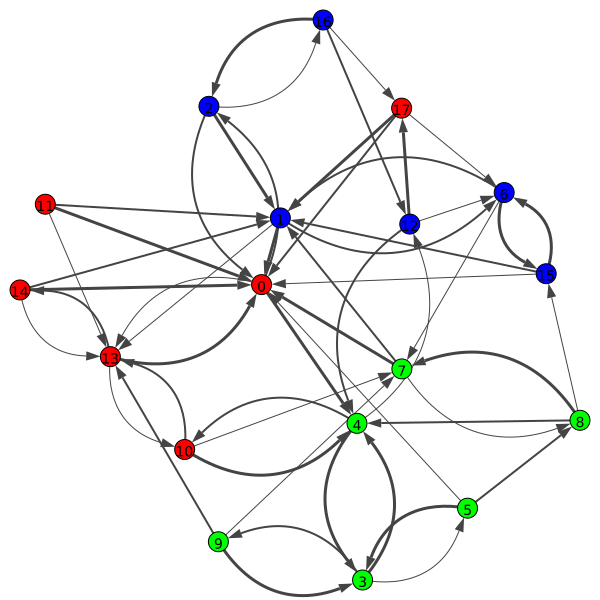

In [56]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=j+1)
g.vs["label"] = listLabel
colors = ["red", "green", "blue"]
g.vs["color"] = [colors[np.argmax(x[i])] for i in range(n-1)]
plot(g)

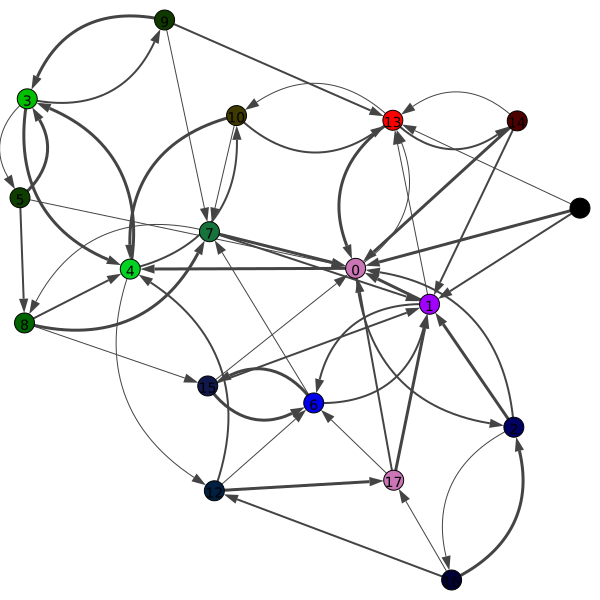

In [54]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=j+1)
g.vs["label"] = listLabel
colors = ["blue", "red", "green"]
#g.vs["color"] = [colors[np.argmax(x[i])] for i in range(n-1)]
g.vs["color"] = [(2*x[i,0], 2*x[i,1], 2*x[i,2]) for i in range(n-1)]
plot(g)

### Result Community detection

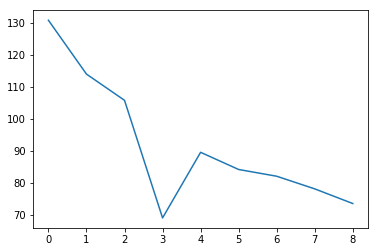

In [10]:
minimumCom = [130.8362029816618, 114.01476200001125, 105.82321499685892, 69.08373001369449, 89.58049409903866, 84.21136471929637, 82.10580687631595, 78.15845648188775, 73.5771903316795]
plt.plot(minimumCom)